In [2]:
import pandas as pd
import numpy as np
import os
import gc
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
os.chdir('/home/sambeet/data/AV/supremacy/')

In [3]:
train = pd.read_csv('train_jqd04QH.csv')
test = pd.read_csv('test_GYi4Gz5.csv')
train['num_missing'] = train.isnull().sum(axis=1)
test['num_missing'] = test.isnull().sum(axis=1)
missing_columns = ['gender','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job']
for col in missing_columns:
    train[col].fillna('NA',inplace=True)
    test[col].fillna('NA',inplace=True)

train['education_level'][(train.education_level == 'NA') & (train.last_new_job == 'never')] = 'Primary School'
#np.unique(train.last_new_job)

train, val = train_test_split(train,test_size=0.1,random_state=37)

In [4]:
#FEATURE ENGINEERING - based on higher than mean and median of training hours within each category
def th_features(column,train=train,test=test):
    gp_median = train.groupby(column)['training_hours'].median().reset_index().rename({'training_hours':column+'_th_median'},axis=1)
    gp_mean = train.groupby(column)['training_hours'].mean().reset_index().rename({'training_hours':column+'_th_mean'},axis=1)
    train = train.merge(gp_median,on=column,how='left')
    train = train.merge(gp_mean,on=column,how='left')
    test = test.merge(gp_median,on=column,how='left')
    test = test.merge(gp_mean,on=column,how='left')
    train[column+'_higher_th_median_ind'] = train.training_hours > train[column+'_th_median']
    train[column+'_higher_th_mean_ind'] = train.training_hours > train[column+'_th_mean']
    test[column+'_higher_th_median_ind'] = test.training_hours > test[column+'_th_median']
    test[column+'_higher_th_mean_ind'] = test.training_hours > test[column+'_th_mean']
    train.drop([column+'_th_mean',column+'_th_median'],axis=1,inplace=True)
    test.drop([column+'_th_mean',column+'_th_median'],axis=1,inplace=True)
    return train,test

def count_features(column,train=train,test=test):
    gp_count = train.groupby(column)['city_development_index'].count().reset_index().rename({'city_development_index':column+'_count'},axis=1)
    train = train.merge(gp_count,on=column,how='left')
    test = test.merge(gp_count,on=column,how='left')
    return train,test

def cdi_features(column,train=train,test=test):
    try:
        column_name = column
        gp_median = train.groupby(column)['city_development_index'].median().reset_index().rename({'city_development_index':column_name+'_cdi_median'},axis=1)
        gp_mean = train.groupby(column)['city_development_index'].mean().reset_index().rename({'city_development_index':column_name+'_cdi_mean'},axis=1)
        gp_sd = train.groupby(column)['city_development_index'].std().reset_index().rename({'city_development_index':column_name+'_cdi_sd'},axis=1)
        gp_skew = train.groupby(column)['city_development_index'].skew().reset_index().rename({'city_development_index':column_name+'_cdi_skew'},axis=1)
        gp_kurtosis = train.groupby(column)['city_development_index'].apply(lambda x:x.kurtosis()).reset_index().rename({'city_development_index':column_name+'_cdi_kurtosis'},axis=1)
    except:
        column_name = 'gp'
        for col in column:
            column_name = column_name + '_' + col
        gp_median = train.groupby(column)['city_development_index'].median().reset_index().rename({'city_development_index':column_name+'_cdi_median'},axis=1)
        gp_mean = train.groupby(column)['city_development_index'].mean().reset_index().rename({'city_development_index':column_name+'_cdi_mean'},axis=1)
        gp_sd = train.groupby(column)['city_development_index'].std().reset_index().rename({'city_development_index':column_name+'_cdi_sd'},axis=1)
        gp_skew = train.groupby(column)['city_development_index'].skew().reset_index().rename({'city_development_index':column_name+'_cdi_skew'},axis=1)
        gp_kurtosis = train.groupby(column)['city_development_index'].apply(lambda x:x.kurtosis()).reset_index().rename({'city_development_index':column_name+'_cdi_kurtosis'},axis=1)
    train = train.merge(gp_median,on=column,how='left')
    train = train.merge(gp_mean,on=column,how='left')
    train = train.merge(gp_sd,on=column,how='left')
    train = train.merge(gp_skew,on=column,how='left')
    train = train.merge(gp_kurtosis,on=column,how='left')
    test = test.merge(gp_median,on=column,how='left')
    test = test.merge(gp_mean,on=column,how='left')
    test = test.merge(gp_sd,on=column,how='left')
    test = test.merge(gp_skew,on=column,how='left')
    test = test.merge(gp_kurtosis,on=column,how='left')
    train[column_name+'_higher_cdi_median_ind'] = train.city_development_index > train[column_name+'_cdi_median']
    test[column_name+'_higher_cdi_median_ind'] = test.city_development_index > test[column_name+'_cdi_median']
    train[column_name+'_higher_cdi_mean_ind'] = train.city_development_index > train[column_name+'_cdi_mean']
    test[column_name+'_higher_cdi_mean_ind'] = test.city_development_index > test[column_name+'_cdi_mean']
    return train,test

def mean_features(column,train=train,test=test):
    try:
        column_name = column+'_mean'
    except:
        column_name = 'gp'
        for col in column:
            column_name = column_name + '_' + col
        column_name = column_name + '_mean'
    gp_mean = train.groupby(column)['target'].mean().reset_index().rename({'target':column_name},axis=1)
    train = train.merge(gp_mean,on=column,how='left')
    test = test.merge(gp_mean,on=column,how='left')
    return train,test

def preferred_features(column1,column2,train=train,test=test):
    preferred = train.groupby(column1)[column2].apply(lambda x: x.mode()).reset_index().rename({column2:'preferred_'+column1+'_'+column2},axis=1)
    preferred = preferred[preferred.level_1 == 0].drop(['level_1'],axis=1)
    train = train.merge(preferred,on=column1,how='left')
    test = test.merge(preferred,on=column1,how='left')
    return train,test

categorical_columns = ['city','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job']
new_categorical_columns = []
for column in categorical_columns:
    print 'Creating features from {}'.format(column)
    train,test = th_features(column,train,test)
    train,test = count_features(column,train,test)
    train,test = mean_features(column,train,test)
    new_categorical_columns.append(column+'_higher_th_median_ind')
    new_categorical_columns.append(column+'_higher_th_mean_ind')
    if column != 'city' and column != 'company_size':
        train,test = cdi_features(column,train,test)
        train,test = preferred_features('city',column,train,test)
        train,test = preferred_features('company_size',column,train,test)
        new_categorical_columns.append(column+'_higher_cdi_median_ind')
        new_categorical_columns.append(column+'_higher_cdi_mean_ind')
        new_categorical_columns.append('preferred_'+'city_'+column)
        new_categorical_columns.append('preferred_'+'company_size_'+column)
    elif column == 'city':
        train,test = preferred_features('company_size',column,train,test)
        new_categorical_columns.append('preferred_'+'company_size_'+column)
    else:
        train,test = cdi_features(column,train,test)
        train,test = preferred_features('city',column,train,test)
        new_categorical_columns.append(column+'_higher_cdi_median_ind')
        new_categorical_columns.append(column+'_higher_cdi_mean_ind')
        new_categorical_columns.append('preferred_'+'city_'+column)

Creating features from city
Creating features from gender
Creating features from relevent_experience
Creating features from enrolled_university
Creating features from education_level
Creating features from major_discipline
Creating features from experience
Creating features from company_size
Creating features from company_type
Creating features from last_new_job


In [5]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)
categorical_columns = categorical_columns + new_categorical_columns
for col in categorical_columns:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    print 'Transforming {}...'.format(col)
    encoder = LabelEncoder()
    encoder.fit(train[col].append(test[col]).astype(str))
    train[col] = encoder.transform(train[col].astype(str))
    test[col] = encoder.transform(test[col].astype(str))
predictor_columns = list(train.columns.values)
predictor_columns.remove('enrollee_id')
predictor_columns.remove('target')
target_columns = 'target'

Transforming city...
Transforming gender...
Transforming relevent_experience...
Transforming enrolled_university...
Transforming education_level...
Transforming major_discipline...
Transforming experience...
Transforming company_size...
Transforming company_type...
Transforming last_new_job...
Transforming city_higher_th_median_ind...
Transforming city_higher_th_mean_ind...
Transforming preferred_company_size_city...
Transforming gender_higher_th_median_ind...
Transforming gender_higher_th_mean_ind...
Transforming gender_higher_cdi_median_ind...
Transforming gender_higher_cdi_mean_ind...
Transforming preferred_city_gender...
Transforming preferred_company_size_gender...
Transforming relevent_experience_higher_th_median_ind...
Transforming relevent_experience_higher_th_mean_ind...
Transforming relevent_experience_higher_cdi_median_ind...
Transforming relevent_experience_higher_cdi_mean_ind...
Transforming preferred_city_relevent_experience...
Transforming preferred_company_size_relevent

#Boruta Feature Selection
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

X = train[predictor_columns].values
y = train[target_columns].values
rfc = RandomForestClassifier(n_estimators=5000, n_jobs=-1, class_weight='balanced', max_depth=3)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=1,perc=100,two_step=False)
start_time = timer(None)
boruta_selector.fit(X, y)
timer(start_time)

# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)

feature_df = pd.DataFrame(train[predictor_columns].columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))

predictor_columns = list(feature_df.head(boruta_selector.n_features_).features)
predictor_columns.append('training_hours')
predictor_columns.append('gender')
categorical_columns = ['gender','city','last_new_job_higher_th_median_ind_cdi',
                       'education_level_higher_th_median_ind_cdi','major_discipline_higher_th_median_ind_cdi',
                       'company_size_higher_th_median_ind_cdi','company_type_higher_th_median_ind_cdi',
                       'experience_higher_th_median_ind_cdi','relevent_experience_higher_th_median_ind_cdi',
                       'enrolled_university_higher_th_median_ind_cdi','gender_higher_th_median_ind_cdi',
                       'last_new_job','company_type','education_level','major_discipline','company_size',
                       'experience','enrolled_university','relevent_experience']

In [12]:
rounds = 5000
early_stop_rounds = 200
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric' : 'auc',
    'num_leaves' : 15,
    'max_depth': 6,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.25,
    'bagging_fraction' : 0.6,
    'bagging_freq' : 20,
    'verbosity' : 0,
    'num_threads' : 8,
    'min_data_in_leaf' : 15,
    'lambda_l1' : 1.2,
    'lambda_l2' : 0.9,
    'cat_smooth' : 100,
    'max_bin' : 25,
    'min_gain_to_split' : 0.005,
    'max_cat_to_onehot' : 200,
    'scale_pos_weight' : 6
}

num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)

5

from imblearn.over_sampling import RandomOverSampler
predictor_columns = list(train.columns.values)
predictor_columns.remove('enrollee_id')
predictor_columns.remove('target')
X = train.loc[:,predictor_columns].values
y = train.target.values
sm = RandomOverSampler(ratio='minority',random_state=37)
X_res, y_res = sm.fit_sample(X, y)

In [13]:
import collections as cl
results_train = []
results_valid = []
feature_importance = dict()
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = train.loc[train_index,predictor_columns].values
    X_test = train.loc[test_index,predictor_columns].values
    y_train = train.loc[train_index,target_columns].values
    y_test = train.loc[test_index,target_columns].values
    X_train = lgb.Dataset(X_train,y_train,feature_name=predictor_columns,categorical_feature = categorical_columns)
    X_test = lgb.Dataset(X_test,y_test,feature_name=predictor_columns,categorical_feature = categorical_columns)
    gc.collect()
    print 'Starting training on fold:',i
    model = lgb.train(lgbm_params,X_train,num_boost_round=rounds,valid_sets=[X_train,X_test],valid_names=['train','valid'],
                    early_stopping_rounds=early_stop_rounds,verbose_eval=0)
    results_train.append(model.best_score['train']['auc'])
    results_valid.append(model.best_score['valid']['auc'])
    test['target_' + str(i)] = model.predict(test.loc[:,predictor_columns].values)
    total_gain = np.sum(model.feature_importance('gain'))
    if i == 1:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance.update({feature : importance/total_gain})
    else:
        for feature, importance in zip(model.feature_name(),model.feature_importance('gain')):
            feature_importance[feature] = feature_importance[feature] + (importance/total_gain)
for feature,importance in zip(feature_importance.keys(),feature_importance.values()):
    feature_importance[feature] = 100*importance/num_folds
feature_importance = cl.OrderedDict(sorted(feature_importance.items(), key=lambda t: t[1], reverse=True))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1
Starting training on fold: 2
Starting training on fold: 3
Starting training on fold: 4
Starting training on fold: 5
Train:0.7265235305234894+-0.022888544021517503 Valid:0.6798372710147552+-0.004443090690233684


In [14]:
test['target'] = 0
for i in range(1,num_folds+1):
    test['target_'+str(i)] = test['target_'+str(i)].rank(pct=True)
    test['target'] = test['target'] + test['target_'+str(i)]
test['target'] = test['target']/float(num_folds)
test[['enrollee_id','target']].to_csv('sub_sam_lgb.csv',index=False)

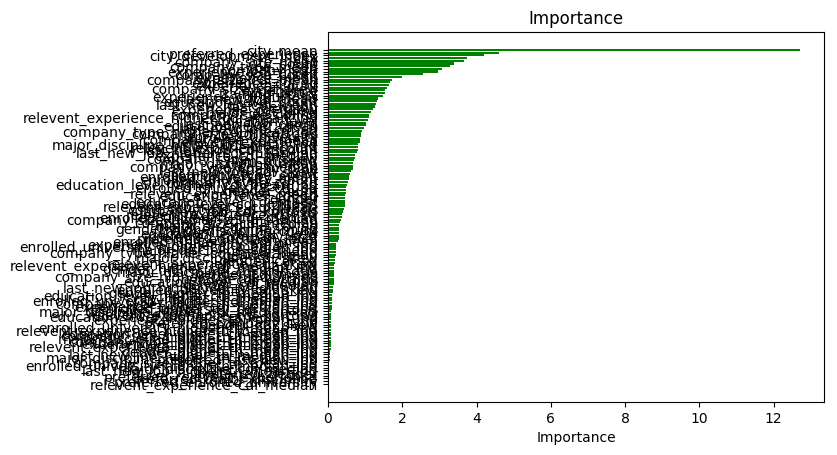

In [58]:
plt.rcdefaults()
fig, ax = plt.subplots()
# Example data
y_pos = np.arange(len(feature_importance.keys()))
ax.barh(y_pos, feature_importance.values(),  align='center',color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_importance.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Importance')
plt.show()

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)
X = pd.get_dummies(columns=categorical_columns,data=train[predictor_columns],drop_first=True)
X_t = pd.get_dummies(columns=categorical_columns,data=test[predictor_columns],drop_first=True)
results_train = []
results_valid = []
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = X.loc[train_index,:].values
    X_test = X.loc[test_index,:].values
    y_train = train.loc[train_index,target_columns].values
    y_test = train.loc[test_index,target_columns].values
    gc.collect()
    print 'Starting training on fold:',i
    model = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=8, min_samples_split=10, 
                                   min_samples_leaf=5,max_features=25,n_jobs=-1,random_state=37,bootstrap=True)
    model.fit(X=X_train,y=y_train)
    results_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
    results_valid.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    test['target_rf_' + str(i)] = model.predict_proba(X_t.values)[:,1]
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1


KeyboardInterrupt: 

In [847]:
test['target'] = 0
for i in range(1,num_folds+1):
    test['target_rf'+str(i)] = test['target_rf_'+str(i)].rank(pct=True)
    test['target'] = test['target'] + test['target_rf_'+str(i)]
test['target'] = test['target']/float(num_folds)
test[['enrollee_id','target']].to_csv('sub_sam_rf.csv',index=False)

In [918]:
from xgboost import XGBClassifier
num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)
X = pd.get_dummies(columns=categorical_columns,data=train[predictor_columns],drop_first=True)
X_t = pd.get_dummies(columns=categorical_columns,data=test[predictor_columns],drop_first=True)
results_train = []
results_valid = []
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = X.loc[train_index,:].values
    X_test = X.loc[test_index,:].values
    y_train = train.loc[train_index,target_columns].values
    y_test = train.loc[test_index,target_columns].values
    gc.collect()
    print 'Starting training on fold:',i
    model = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=5000, silent=False, objective='binary:logistic',
                          booster='gbtree', n_jobs=-1, gamma=0, min_child_weight=0, max_delta_step=0, subsample=0.8,
                          colsample_bytree=0.15, colsample_bylevel=0.8, reg_alpha=0.5, reg_lambda=1.6, scale_pos_weight=3)
    model.fit(X=X_train,y=y_train, verbose=False, eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=200)
    test['target_xgb_' + str(i)] = model.predict_proba(X_t.values)[:,1]
    results_train.append(np.max(model.evals_result_['validation_0']['auc']))
    results_valid.append(np.max(model.evals_result_['validation_1']['auc']))
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1
Starting training on fold: 2
Starting training on fold: 3
Starting training on fold: 4
Starting training on fold: 5
Train:0.75837+-0.024407120665904048 Valid:0.6778966000000001+-0.006972702506202325


In [919]:
test['target'] = 0
for i in range(1,num_folds+1):
    test['target_xgb_'+str(i)] = test['target_xgb_'+str(i)].rank(pct=True)
    test['target'] = test['target'] + test['target_xgb_'+str(i)]
test['target'] = test['target']/float(num_folds)
test[['enrollee_id','target']].to_csv('sub_sam_xgb.csv',index=False)

In [794]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score
num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)
X = pd.get_dummies(columns=categorical_columns,data=train[predictor_columns],drop_first=True)
X_t = pd.get_dummies(columns=categorical_columns,data=test[predictor_columns],drop_first=True)
results_train = []
results_valid = []
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = X.loc[train_index,:].values
    X_test = X.loc[test_index,:].values
    y_train = train.loc[train_index,target_columns].values
    y_test = train.loc[test_index,target_columns].values
    gc.collect()
    print 'Starting training on fold:',i
    model = ExtraTreesClassifier(n_estimators=3000, criterion='entropy', max_depth=8, min_samples_split=50, 
                                 min_samples_leaf=15,max_features=300,min_impurity_decrease=0.0, 
                                 bootstrap=True, n_jobs=-1, random_state=37)
    model.fit(X=X_train,y=y_train)
    results_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
    results_valid.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    test['target_et_' + str(i)] = model.predict_proba(X_t.values)[:,1]
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1
Starting training on fold: 2
Starting training on fold: 3
Starting training on fold: 4
Starting training on fold: 5
Train:0.7581600538234055+-0.0020969330747042402 Valid:0.6746285776006717+-0.00573772755124784


In [795]:
test['target'] = 0
for i in range(1,num_folds+1):
    test['target_et_'+str(i)] = test['target_et_'+str(i)].rank(pct=True)
    test['target'] = test['target'] + test['target_et_'+str(i)]
test['target'] = test['target']/float(num_folds)
test[['enrollee_id','target']].to_csv('sub_sam_et.csv',index=False)

In [920]:
import catboost as cb
from sklearn.metrics import roc_auc_score
cat_features_index = []
for cat in categorical_columns:
    for pred in predictor_columns:
        if cat == pred:
            cat_features_index.append(predictor_columns.index(cat))
num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=True,random_state=37)
kf.get_n_splits(train)
results_train = []
results_valid = []
for i, (train_index, test_index) in zip(range(1,num_folds+1),kf.split(train)):
    X_train = train.loc[train_index,predictor_columns].values
    X_test = train.loc[test_index,predictor_columns].values
    y_train = train.loc[train_index,target_columns].values
    y_test = train.loc[test_index,target_columns].values
    gc.collect()
    print 'Starting training on fold:',i
    model = cb.CatBoostClassifier(eval_metric="AUC",depth=7,iterations= 2000, l2_leaf_reg=1,learning_rate=0.01)
    model.fit(X_train,y_train, cat_features= cat_features_index,eval_set=(X_test,y_test),verbose=500)
    results_train.append(roc_auc_score(y_train,model.predict_proba(X_train)[:,1]))
    results_valid.append(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
    test['target_cb_' + str(i)] = model.predict_proba(test.loc[:,predictor_columns].values)[:,1]
print 'Train:' + str(np.mean(results_train)) + '+-' + str(np.std(results_train)), 'Valid:' + str(np.mean(results_valid)) + '+-' + str(np.std(results_valid))

Starting training on fold: 1
0:	learn: 0.5936893	test: 0.5835502	best: 0.5835502 (0)	total: 119ms	remaining: 3m 58s
500:	learn: 0.7161085	test: 0.6716077	best: 0.6716241 (495)	total: 20.9s	remaining: 1m 2s
1000:	learn: 0.7494776	test: 0.6765742	best: 0.6765742 (1000)	total: 44.7s	remaining: 44.6s
1500:	learn: 0.7824819	test: 0.6800797	best: 0.6801144 (1498)	total: 1m 13s	remaining: 24.3s

bestTest = 0.6827735825
bestIteration = 1998

Shrink model to first 1999 iterations.
Starting training on fold: 2
0:	learn: 0.6265911	test: 0.6281028	best: 0.6281028 (0)	total: 42.2ms	remaining: 1m 24s
500:	learn: 0.7196647	test: 0.6723643	best: 0.6723643 (500)	total: 20.7s	remaining: 1m 1s
1000:	learn: 0.7547932	test: 0.6765499	best: 0.6767087 (878)	total: 45.2s	remaining: 45.1s
1500:	learn: 0.7858820	test: 0.6785922	best: 0.6787045 (1482)	total: 1m 13s	remaining: 24.4s

bestTest = 0.6797942111
bestIteration = 1925

Shrink model to first 1926 iterations.
Starting training on fold: 3
0:	learn: 0.64079

In [921]:
test['target'] = 0
for i in range(1,num_folds+1):
    test['target_cb_'+str(i)] = test['target_cb_'+str(i)].rank(pct=True)
    test['target'] = test['target'] + test['target_cb_'+str(i)]
test['target'] = test['target']/float(num_folds)
test[['enrollee_id','target']].to_csv('sub_sam_cb.csv',index=False)

In [922]:
#Ensemble
sub1 = pd.read_csv('sub_sam_lgb.csv') #0.6892
sub2 = pd.read_csv('sub_sam_xgb.csv') #0.6871
sub3 = pd.read_csv('sub_sam_rf.csv') #0.6871
sub4 = pd.read_csv('sub_sam_et.csv') #0.6878
sub5 = pd.read_csv('sub_sam_cb.csv') #0.6832
pd.concat([sub1.target,sub2.target,sub3.target,sub4.target,sub5.target],axis=1).corr()

,target,target,target,target,target
target,1.000000,0.987574,0.905757,0.974945,0.950666
target,0.987574,1.000000,0.903539,0.970840,0.962152
target,0.905757,0.903539,1.000000,0.902067,0.872290
target,0.974945,0.970840,0.902067,1.000000,0.926395
target,0.950666,0.962152,0.872290,0.926395,1.000000


In [937]:
test['target'] = (0.5*sub1.target + 0.35*sub3.target + 0.15*sub4.target)
test[['enrollee_id','target']].to_csv('sub_sam_lgb_rf_et_ensemble.csv',index=False)

group = 'company_type'
check = 'gender'
x = train.groupby([group,check])['target'].count().reset_index()
y = train.groupby([group])['target'].count().reset_index()
x = x.merge(y,on=group,how='left')
x['pct_missing'] = x['target_x']/x['target_y']
x[[group,check,'pct_missing','target_y']][x[check] == 'NA']

#could be binned into urban and rural on the basis of city development index
train.groupby('city')['target'].agg(['count','mean']).sort_values('count')
#NA looks like female or others  
train.groupby('gender')['target'].agg(['count','mean']).sort_values('count')
#train['gender'][train.gender!='Male'] = 'Not Male'
#test['gender'][test.gender!='Male'] = 'Not Male'
#NA should be treated as a separate category - do nothin
train.groupby('enrolled_university')['target'].agg(['count','mean']).sort_values('count')
#NA imputed as 'Graduate'
train.groupby('education_level')['target'].agg(['count','mean']).sort_values('count')
#train['education_level'][train.education_level=='NA'] = 'Graduate'
#test['education_level'][test.education_level=='NA'] = 'Graduate'
#NA treated as separate category given higher number of missing - STEM vs non-stem
train.groupby('major_discipline')['target'].agg(['count','mean']).sort_values('count')
#NA treated as <1 as almost similar event rate and only 59 instances
train.groupby('experience')['target'].agg(['count','mean']).sort_values('count')
#train['experience'][train.experience=='NA'] = '<1'
#test['experience'][test.experience=='NA'] = '<1'
#NA treated as separate category given the high event rate and instances - do nothing
train.groupby('company_size')['target'].agg(['count','mean']).sort_values('count')
#NA treated as separate category given the high event rate and instances - do nothing
train.groupby('company_type')['target'].agg(['count','mean']).sort_values('count')
#NA treated as separate category given the high event rate - do nothing
train.groupby('last_new_job')['target'].agg(['count','mean']).sort_values('count')

#Higher training hours compared to others within the group is an indicator of job change interest
fig, ax = plt.subplots(figsize=(15,10))
sns.violinplot(ax=ax,data=train,x='num_missing',y='city_development_index',hue='target',split=True,inner="quart")

sns.lmplot(data=train,y='city_development_index',x='training_hours',hue='target')

#Interest to change job is higher in less developed cities
sns.boxplot(data=train,x='target',y='city_development_index')

from imblearn.over_sampling import SMOTE
predictor_columns = list(train.columns.values)
predictor_columns.remove('enrollee_id')
predictor_columns.remove('target')
X = train.loc[:,predictor_columns]
y = train.target.values
sm = SMOTE(ratio='minority',random_state=37)
X_res, y_res = sm.fit_sample(X, y)

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def noisy_mean_features(column,train=train,test=test,multiplier=1000.0):
    prior = train.target.mean()
    column_name = 'gp'
    for col in column:
        column_name = column_name + '_' + col
    column_name = column_name + '_mean'
    gp_mean = train.groupby(column)['target'].agg(['sum','count']).reset_index()
    y = (gp_mean['sum'] + multiplier*prior)/(gp_mean['count'] + multiplier)
    gp_mean[column_name] = add_noise(y,0.000000)
    gp_mean.drop(['sum','count'],axis=1,inplace=True)
    train = train.merge(gp_mean,on=column,how='left')
    test = test.merge(gp_mean,on=column,how='left')
    return train,test

def gp_count_features(column,train=train,test=test):
    column_name = 'gp'
    for col in column:
        column_name = column_name + '_' + col
    column_name = column_name + '_count'
    gp_count = train.groupby(column)['city_development_index'].count().reset_index().rename({'city_development_index':column_name},axis=1)
    train = train.merge(gp_count,on=column,how='left')
    test = test.merge(gp_count,on=column,how='left')
    return train,test

groups = [['company_type','company_size']]
for group in groups:
    train,test = cdi_features(group,train,test)